# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [24]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -3 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [25]:
#################### Classify template samples  ##################
def sample_classifier(df_temp):
    DecayMode = {'bkg_fakeD':0,           'bkg_continuum':1,    'bkg_combinatorial':2,
                 'bkg_Odecay':3,          'bkg_fakeTC':4,       r'$D\tau\nu$':5,
                 r'$D^\ast\tau\nu$':6,    r'$D\ell\nu$':7,      r'$D^\ast\ell\nu$':8,
                 r'$D^{\ast\ast}\tau\nu$':[9,10],               r'res_$D^{\ast\ast}\ell\nu$':[11,14],
                 r'gap_non_$D^{\ast\ast}\ell\nu$':[12,13,15],   'bkg_others':16}

    templates = {}

    for name, mode in DecayMode.items():
        if type(DecayMode[name])==int:
            sample = df_temp.query(f'mode=={DecayMode[name]}')
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        elif type(DecayMode[name])==list:
            nModes = len(DecayMode[name])
            query_string = f'mode=={DecayMode[name][0]}'
            for i in range(nModes):
                if i==0:
                    continue
                else:
                    query_string += f' or mode=={DecayMode[name][i]}'
            sample = df_temp.query(query_string)
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        else:
            raise TypeError('Error: mode has to be an int or a list')
    return templates

In [26]:
sample_lists = ['subset_0.root:B0',
                'subset_1.root:B0',
                'subset_2.root:B0',
                'subset_3.root:B0',
                'subset_4.root:B0',
                'subset_5.root:B0',
                'subset_6.root:B0',
                'subset_7.root:B0',
                'subset_8.root:B0',
]


if template_with_FakeD:
    input_cut = '((5<=mode) & (mode<=15)) | (mode==0)'
else:
    input_cut = '(5<=mode) & (mode<=15)'

columns = util.all_relevant_variables


# Load template samples
temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/subset_*.root:B0'],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_temp = pd.DataFrame(temp)

# Define the minimum bin counts
bin_threshold = 1
df_temp['__weight__'] = 1

templates=sample_classifier(df_temp)


#################### Create template 2d histograms ################


t_histograms = {}
t_staterr = {}
for name, df in templates.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    t_histograms[name] = counts.T
    t_staterr[name] = np.sqrt(staterr_squared.T)



################### Trimming and flattening ###############
# remove bins with count smaller than bin_threshold
indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
template_flat = {name:t[indices_threshold].tolist() for name,t in t_histograms.items()}
staterr_flat = {name:se[indices_threshold].tolist() for name,se in t_staterr.items()}

asimov_data = np.sum(list(template_flat.values()),axis=0)

In [32]:
# Create template histograms
t_histograms_sr = {}
t_staterr_sr = {}
for name, template in templates_sr.items():
    
    (counts_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr_sr[name] = np.sqrt(staterr_squared_sr).T
    t_histograms_sr[name] = counts_sr.T
    
# Create data histogram
(d_histogram_sr, xedges, yedges) = np.histogram2d(data_sr['B0_CMS3_weMissM2'], 
                                               data_sr['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data_sr['__weight__'])
d_histogram_sr = d_histogram_sr.T
    
indices_threshold_sr = np.where(np.sum(list(t_histograms_sr.values()),axis=0) >= bin_threshold)
template_flat_sr = {name:list(t[indices_threshold_sr]) for name,t in t_histograms_sr.items()}
staterr_flat_sr = {name:list(se[indices_threshold_sr]) for name,se in t_staterr_sr.items()}
# data = counts.ravel().to_list()
data_flat_sr = list(d_histogram_sr[indices_threshold_sr])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


# 2. Create a pyhf workspace

In [3]:
workspace_path = "R_D_2d_workspace_withFakeDinSR.json"
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        1.0,
                        1.0,
                        5.0,
                        5.0,
                        7.0,
                        2.0,
                        4.0,
                        5.0,
                        13.0,
                        11.0,
                        16.0,
                        7.0,
                        1.0,
                        1.0,
                        5.0,
                        4.0,
                        11.0,
                        20.0,
                        15.0,
                        21.0,
                        21.0,
                        14.0,
                        1.0,
                        1.0,
                        4.0,
                        6.0,
                        11.0,
                        13.0,
                        25.0,
            

In [28]:
# update templates and data in the workspace
# signal region
names = list(template_flat.keys())
for i, sample_SignalRegion in enumerate(spec['channels'][0]['samples']):
    spec['channels'][0]['samples'][i]['name'] = names[i]
    spec['channels'][0]['samples'][i]['data'] = template_flat[names[i]]
    for j,m in enumerate(sample_SignalRegion['modifiers']):
        if m['type']=='staterror':
#             spec['channels'][0]['samples'][i]['modifiers'].remove(m)
            spec['channels'][0]['samples'][i]['modifiers'][j]['data'] = staterr_flat[names[i]]
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = 'staterror_signal_region'
        elif m['type']=="normfactor":
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = names[i]+'_norm'
        else:
            print(m['type'],'is turned on')

            
spec['observations'][0]['data']=asimov_data.tolist()

for i, par in enumerate(spec["measurements"][0]["config"]["parameters"]):
    par['name']=names[i]+'_norm'
    par['bounds'] = [[-1,1]]
    par['inits'] = [0.5]
    
spec["measurements"][0]["config"]['poi']="$D\\tau\\nu$_norm"

print(json.dumps(spec, sort_keys=True, indent=4))

#cabinetry.workspace.save(spec, '../Toys_pipeline/R_D_2d_workspace_withFakeDinSR.json')

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        1.0,
                        3.0,
                        7.0,
                        11.0,
                        14.0,
                        18.0,
                        1.0,
                        2.0,
                        6.0,
                        8.0,
                        19.0,
                        31.0,
                        31.0,
                        35.0,
                        25.0,
                        0.0,
                        2.0,
                        6.0,
                        11.0,
                        14.0,
                        18.0,
                        40.0,
                        61.0,
                        53.0,
                        68.0,
                        65.0,
                        33.0,
                        1.0,
                        2.0,
       

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (756 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


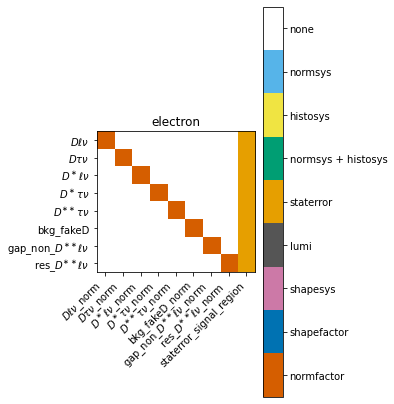

In [4]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [5]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (756 new nuisance parameters)


In [6]:
toy_pars = model.config.suggested_init()
rng = np.random.default_rng(0)
toy_pars[:8] = list(rng.uniform(0.01,0.2,8))
minos_parameters = model.config.parameters[:8]
minos_parameters.remove('bkg_fakeD_norm')

# generate the toys:
pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))
toys = pdf_toy.sample((2,))
fix_par = [False,False,False,False,False,True,False,False]
toy_pars[:8]

[0.1310227205910763,
 0.06125947561513536,
 0.01778496954787699,
 0.013140250750420529,
 0.16452134544805178,
 0.18342355968276713,
 0.12526079739576418,
 0.1486043465869597]

In [32]:
pyhf.set_backend('jax', 'scipy')
init_pars = pyhf.infer.mle.fit(data=toys[0], pdf=model,
                               init_pars=toy_pars,
                               fixed_params=fix_par).tolist()
init_pars[:8]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/belle/zhangboy/.local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


[0.13169982353663728,
 0.08990525786653858,
 0.015827152457776366,
 0.030493148727632854,
 0.05369046523544816,
 0.18342355968276713,
 0.1770106180224747,
 0.1368522594222745]

In [33]:
pyhf.set_backend('jax', 'minuit')
res = cabinetry.fit.fit(
    model,
    data=toys[0],
    init_pars=init_pars,
    fix_pars = fix_par,
    # par_bounds=par_bounds,
    goodness_of_fit=True,
    minos=minos_parameters
)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2035                       │       Nfcn = 327434, Ngrad = 1       │
│ EDM = 3.08e-06 (Goal: 0.0002)    │           time = 213.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_signal_region[68]        =  0.9997 +/- 0.0522
INFO - cabinetry.fit - staterror_signal_region[69]        =  1.0443 +/- 0.0544
INFO - cabinetry.fit - staterror_signal_region[70]        =  1.0312 +/- 0.0599
INFO - cabinetry.fit - staterror_signal_region[71]        =  0.9628 +/- 0.0808
INFO - cabinetry.fit - staterror_signal_region[72]        =  0.7665 +/- 0.1885
INFO - cabinetry.fit - staterror_signal_region[73]        =  1.2712 +/- 0.9850
INFO - cabinetry.fit - staterror_signal_region[74]        =  0.0000 +/- 1.0995
INFO - cabinetry.fit - staterror_signal_region[75]        =  1.2759 +/- 0.3564
INFO - cabinetry.fit - staterror_signal_region[76]        =  1.3085 +/- 0.2639
INFO - cabinetry.fit - staterror_signal_region[77]        =  1.1030 +/- 0.1926
INFO - cabinetry.fit - staterror_signal_region[78]        =  1.0489 +/- 0.1610
INFO - cabinetry.fit - staterror_signal_region[79]        =  1.0754 +/- 0.1242
INFO - cabinetry.fit - staterror_signal_region[80]  

INFO - cabinetry.fit - staterror_signal_region[172]       =  1.0240 +/- 0.0318
INFO - cabinetry.fit - staterror_signal_region[173]       =  0.9659 +/- 0.0322
INFO - cabinetry.fit - staterror_signal_region[174]       =  0.9875 +/- 0.0328
INFO - cabinetry.fit - staterror_signal_region[175]       =  0.9938 +/- 0.0358
INFO - cabinetry.fit - staterror_signal_region[176]       =  0.9864 +/- 0.0423
INFO - cabinetry.fit - staterror_signal_region[177]       =  0.9745 +/- 0.0997
INFO - cabinetry.fit - staterror_signal_region[178]       =  2.0485 +/- 0.8912
INFO - cabinetry.fit - staterror_signal_region[179]       =  0.7884 +/- 0.3155
INFO - cabinetry.fit - staterror_signal_region[180]       =  1.1640 +/- 0.2042
INFO - cabinetry.fit - staterror_signal_region[181]       =  0.9854 +/- 0.1662
INFO - cabinetry.fit - staterror_signal_region[182]       =  1.1209 +/- 0.1715
INFO - cabinetry.fit - staterror_signal_region[183]       =  0.7553 +/- 0.1137
INFO - cabinetry.fit - staterror_signal_region[184] 

INFO - cabinetry.fit - staterror_signal_region[276]       =  1.0042 +/- 0.0290
INFO - cabinetry.fit - staterror_signal_region[277]       =  1.0026 +/- 0.0362
INFO - cabinetry.fit - staterror_signal_region[278]       =  0.9668 +/- 0.0685
INFO - cabinetry.fit - staterror_signal_region[279]       =  0.0303 +/- 7.8021
INFO - cabinetry.fit - staterror_signal_region[280]       =  0.1760 +/- 0.5589
INFO - cabinetry.fit - staterror_signal_region[281]       =  0.8183 +/- 0.2262
INFO - cabinetry.fit - staterror_signal_region[282]       =  0.9063 +/- 0.1559
INFO - cabinetry.fit - staterror_signal_region[283]       =  0.7316 +/- 0.1088
INFO - cabinetry.fit - staterror_signal_region[284]       =  1.0784 +/- 0.0927
INFO - cabinetry.fit - staterror_signal_region[285]       =  0.9508 +/- 0.0736
INFO - cabinetry.fit - staterror_signal_region[286]       =  1.0328 +/- 0.0660
INFO - cabinetry.fit - staterror_signal_region[287]       =  0.9969 +/- 0.0539
INFO - cabinetry.fit - staterror_signal_region[288] 

INFO - cabinetry.fit - staterror_signal_region[380]       =  0.9870 +/- 0.0232
INFO - cabinetry.fit - staterror_signal_region[381]       =  0.9943 +/- 0.0227
INFO - cabinetry.fit - staterror_signal_region[382]       =  1.0107 +/- 0.0230
INFO - cabinetry.fit - staterror_signal_region[383]       =  1.0366 +/- 0.0235
INFO - cabinetry.fit - staterror_signal_region[384]       =  1.0248 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[385]       =  1.0154 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[386]       =  1.0057 +/- 0.0276
INFO - cabinetry.fit - staterror_signal_region[387]       =  1.0155 +/- 0.0376
INFO - cabinetry.fit - staterror_signal_region[388]       =  1.0740 +/- 0.1052
INFO - cabinetry.fit - staterror_signal_region[389]       =  2.9815 +/- 0.9921
INFO - cabinetry.fit - staterror_signal_region[390]       =  1.0643 +/- 0.3835
INFO - cabinetry.fit - staterror_signal_region[391]       =  1.5760 +/- 0.6418
INFO - cabinetry.fit - staterror_signal_region[392] 

INFO - cabinetry.fit - staterror_signal_region[484]       =  0.9942 +/- 0.0203
INFO - cabinetry.fit - staterror_signal_region[485]       =  0.9820 +/- 0.0183
INFO - cabinetry.fit - staterror_signal_region[486]       =  1.0037 +/- 0.0170
INFO - cabinetry.fit - staterror_signal_region[487]       =  1.0095 +/- 0.0161
INFO - cabinetry.fit - staterror_signal_region[488]       =  1.0193 +/- 0.0152
INFO - cabinetry.fit - staterror_signal_region[489]       =  1.0047 +/- 0.0165
INFO - cabinetry.fit - staterror_signal_region[490]       =  0.9910 +/- 0.0183
INFO - cabinetry.fit - staterror_signal_region[491]       =  1.0277 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[492]       =  1.0198 +/- 0.0201
INFO - cabinetry.fit - staterror_signal_region[493]       =  1.0117 +/- 0.0216
INFO - cabinetry.fit - staterror_signal_region[494]       =  0.9724 +/- 0.0225
INFO - cabinetry.fit - staterror_signal_region[495]       =  0.9935 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[496] 

INFO - cabinetry.fit - staterror_signal_region[588]       =  1.0403 +/- 0.0513
INFO - cabinetry.fit - staterror_signal_region[589]       =  0.8370 +/- 0.2668
INFO - cabinetry.fit - staterror_signal_region[590]       =  1.2660 +/- 0.1919
INFO - cabinetry.fit - staterror_signal_region[591]       =  1.1182 +/- 0.1609
INFO - cabinetry.fit - staterror_signal_region[592]       =  1.1267 +/- 0.1301
INFO - cabinetry.fit - staterror_signal_region[593]       =  0.9212 +/- 0.1251
INFO - cabinetry.fit - staterror_signal_region[594]       =  0.8169 +/- 0.1040
INFO - cabinetry.fit - staterror_signal_region[595]       =  0.9765 +/- 0.0735
INFO - cabinetry.fit - staterror_signal_region[596]       =  0.9495 +/- 0.0373
INFO - cabinetry.fit - staterror_signal_region[597]       =  0.9654 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[598]       =  1.0025 +/- 0.0212
INFO - cabinetry.fit - staterror_signal_region[599]       =  0.9985 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[600] 

INFO - cabinetry.fit - staterror_signal_region[692]       =  1.0033 +/- 0.0241
INFO - cabinetry.fit - staterror_signal_region[693]       =  1.0432 +/- 0.0205
INFO - cabinetry.fit - staterror_signal_region[694]       =  1.0043 +/- 0.0185
INFO - cabinetry.fit - staterror_signal_region[695]       =  0.9963 +/- 0.0168
INFO - cabinetry.fit - staterror_signal_region[696]       =  1.0052 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[697]       =  1.0397 +/- 0.0208
INFO - cabinetry.fit - staterror_signal_region[698]       =  1.0095 +/- 0.0365
INFO - cabinetry.fit - staterror_signal_region[699]       =  1.2240 +/- 0.2639
INFO - cabinetry.fit - staterror_signal_region[700]       =  0.8275 +/- 0.3168
INFO - cabinetry.fit - staterror_signal_region[701]       =  1.0788 +/- 0.3353
INFO - cabinetry.fit - staterror_signal_region[702]       =  0.9905 +/- 0.5738
INFO - cabinetry.fit - staterror_signal_region[703]       =  0.9614 +/- 0.3509
INFO - cabinetry.fit - staterror_signal_region[704] 

DEBUG - cabinetry.fit - number of degrees of freedom: 787
INFO - cabinetry.fit - p-value for goodness-of-fit test: 93.78%


In [11]:
store_full=True

# prepare containers for fit results
fit_results = {
    'best_twice_nll': [],
    'pval': [],
    'best_fit': []
}
if store_full:
#             fit_results['main_data'] = []
#             fit_results['aux_data'] = []
    fit_results['uncertainty'] = []
    fit_results['minos_uncertainty_up'] = []
    fit_results['minos_uncertainty_down'] = []
    minos_parameters = model.config.par_names[:8]

failed_fits = 0
attempted_fits = 0
successful_fits = 0

# fit toys
with tqdm(total=len(toys), desc='Fitting toys') as pbar:
    while attempted_fits < len(toys):
        data = toys[attempted_fits]

        try:
            if store_full: # minuit and minos
                try:
                    pyhf.set_backend('jax', 'scipy')
                    init_pars = pyhf.infer.mle.fit(data=data, pdf=model,fixed_params=fix_par).tolist()

                except:
                    init_pars = toy_pars


                pyhf.set_backend('jax', 'minuit')
                res = cabinetry.fit.fit(
                    model,
                    data=data,
                    init_pars=init_pars,
                    fix_pars = fix_par,
                    # par_bounds=par_bounds,
                    goodness_of_fit=True,
                    minos=minos_parameters,
                )

                # save fit results
                fit_results['best_twice_nll'].append(res.best_twice_nll)
                fit_results['pval'].append(res.goodness_of_fit)
                fit_results['best_fit'].append(res.bestfit[:8].tolist())

                main_data, aux_data = model.fullpdf_tv.split(pyhf.tensorlib.astensor(data))
#                         fit_results['main_data'].append(main_data.tolist())
#                         fit_results['aux_data'].append(aux_data.tolist())
                fit_results['uncertainty'].append(res.uncertainty[:8].tolist())

                fit_results['minos_uncertainty_up'].append(
                    [abs(res.minos_uncertainty[x][1]) for x in res.labels[:8]])
                fit_results['minos_uncertainty_down'].append(
                    [abs(res.minos_uncertainty[x][0]) for x in res.labels[:8]])

            else: # scipy only
                pyhf.set_backend('jax', 'scipy')
                bestfit_pars, twice_nll = pyhf.infer.mle.fit(data=data, pdf=model, 
                                                             return_fitted_val=True,
                                                             fixed_params=fix_par)

                # save fit results
                fit_results['best_twice_nll'].append(twice_nll.tolist())
                fit_results['best_fit'].append(bestfit_pars[:8].tolist())

            successful_fits += 1
            pbar.update(1)

        except:
            failed_fits += 1
        attempted_fits += 1
    pbar.close()

for key in fit_results.keys():
    # convert to json safe lists (these are much quicker to load then the yaml files later)
    fit_results[key] = np.array(fit_results[key]).tolist()

out_dict = {
    'poi': model.config.par_names[:8],
    'toy_pars': toy_pars[:8],
    'results': fit_results,
    'failed_fits': failed_fits,
    'atempted_fits': attempted_fits
                         }

Fitting toys:   0%|          | 0/10 [00:00<?, ?it/s]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2060                       │      Nfcn = 328369, Ngrad = 36       │
│ EDM = 0.00114 (Goal: 0.0002)     │           time = 208.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

INFO - cabinetry.fit - staterror_signal_region[65]        =  0.9561 +/- 0.0747
INFO - cabinetry.fit - staterror_signal_region[66]        =  1.0602 +/- 0.0641
INFO - cabinetry.fit - staterror_signal_region[67]        =  1.0479 +/- 0.0592
INFO - cabinetry.fit - staterror_signal_region[68]        =  1.0825 +/- 0.0540
INFO - cabinetry.fit - staterror_signal_region[69]        =  1.0891 +/- 0.0541
INFO - cabinetry.fit - staterror_signal_region[70]        =  0.9987 +/- 0.0604
INFO - cabinetry.fit - staterror_signal_region[71]        =  0.8841 +/- 0.0835
INFO - cabinetry.fit - staterror_signal_region[72]        =  0.9336 +/- 0.1865
INFO - cabinetry.fit - staterror_signal_region[73]        =  0.8714 +/- 0.9792
INFO - cabinetry.fit - staterror_signal_region[74]        =  1.9617 +/- 0.8835
INFO - cabinetry.fit - staterror_signal_region[75]        =  1.3632 +/- 0.4073
INFO - cabinetry.fit - staterror_signal_region[76]        =  1.2274 +/- 0.2884
INFO - cabinetry.fit - staterror_signal_region[77]  

INFO - cabinetry.fit - staterror_signal_region[169]       =  1.0572 +/- 0.0396
INFO - cabinetry.fit - staterror_signal_region[170]       =  0.9348 +/- 0.0370
INFO - cabinetry.fit - staterror_signal_region[171]       =  0.9642 +/- 0.0327
INFO - cabinetry.fit - staterror_signal_region[172]       =  1.0019 +/- 0.0314
INFO - cabinetry.fit - staterror_signal_region[173]       =  1.0141 +/- 0.0327
INFO - cabinetry.fit - staterror_signal_region[174]       =  0.9933 +/- 0.0327
INFO - cabinetry.fit - staterror_signal_region[175]       =  1.0327 +/- 0.0362
INFO - cabinetry.fit - staterror_signal_region[176]       =  0.9842 +/- 0.0428
INFO - cabinetry.fit - staterror_signal_region[177]       =  0.9422 +/- 0.0972
INFO - cabinetry.fit - staterror_signal_region[178]       =  0.0000 +/- 1.9007
INFO - cabinetry.fit - staterror_signal_region[179]       =  1.3665 +/- 0.3077
INFO - cabinetry.fit - staterror_signal_region[180]       =  1.2498 +/- 0.2059
INFO - cabinetry.fit - staterror_signal_region[181] 

INFO - cabinetry.fit - staterror_signal_region[273]       =  0.9667 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[274]       =  1.0142 +/- 0.0260
INFO - cabinetry.fit - staterror_signal_region[275]       =  1.0240 +/- 0.0276
INFO - cabinetry.fit - staterror_signal_region[276]       =  0.9827 +/- 0.0287
INFO - cabinetry.fit - staterror_signal_region[277]       =  1.0279 +/- 0.0363
INFO - cabinetry.fit - staterror_signal_region[278]       =  0.9344 +/- 0.0663
INFO - cabinetry.fit - staterror_signal_region[279]       =  0.5963 +/- 0.9701
INFO - cabinetry.fit - staterror_signal_region[280]       =  1.3433 +/- 0.5283
INFO - cabinetry.fit - staterror_signal_region[281]       =  1.2099 +/- 0.2232
INFO - cabinetry.fit - staterror_signal_region[282]       =  1.0654 +/- 0.1611
INFO - cabinetry.fit - staterror_signal_region[283]       =  0.8400 +/- 0.1228
INFO - cabinetry.fit - staterror_signal_region[284]       =  0.9996 +/- 0.0909
INFO - cabinetry.fit - staterror_signal_region[285] 

INFO - cabinetry.fit - staterror_signal_region[377]       =  0.9537 +/- 0.0219
INFO - cabinetry.fit - staterror_signal_region[378]       =  1.0078 +/- 0.0227
INFO - cabinetry.fit - staterror_signal_region[379]       =  0.9627 +/- 0.0225
INFO - cabinetry.fit - staterror_signal_region[380]       =  1.0123 +/- 0.0232
INFO - cabinetry.fit - staterror_signal_region[381]       =  1.0293 +/- 0.0229
INFO - cabinetry.fit - staterror_signal_region[382]       =  1.0405 +/- 0.0229
INFO - cabinetry.fit - staterror_signal_region[383]       =  1.0453 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[384]       =  0.9549 +/- 0.0242
INFO - cabinetry.fit - staterror_signal_region[385]       =  0.9971 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[386]       =  0.9747 +/- 0.0277
INFO - cabinetry.fit - staterror_signal_region[387]       =  0.9841 +/- 0.0373
INFO - cabinetry.fit - staterror_signal_region[388]       =  0.8190 +/- 0.1027
INFO - cabinetry.fit - staterror_signal_region[389] 

INFO - cabinetry.fit - staterror_signal_region[481]       =  1.0084 +/- 0.0305
INFO - cabinetry.fit - staterror_signal_region[482]       =  1.0294 +/- 0.0258
INFO - cabinetry.fit - staterror_signal_region[483]       =  1.0181 +/- 0.0228
INFO - cabinetry.fit - staterror_signal_region[484]       =  1.0024 +/- 0.0203
INFO - cabinetry.fit - staterror_signal_region[485]       =  1.0044 +/- 0.0184
INFO - cabinetry.fit - staterror_signal_region[486]       =  0.9903 +/- 0.0170
INFO - cabinetry.fit - staterror_signal_region[487]       =  1.0116 +/- 0.0161
INFO - cabinetry.fit - staterror_signal_region[488]       =  0.9893 +/- 0.0152
INFO - cabinetry.fit - staterror_signal_region[489]       =  0.9905 +/- 0.0165
INFO - cabinetry.fit - staterror_signal_region[490]       =  0.9873 +/- 0.0183
INFO - cabinetry.fit - staterror_signal_region[491]       =  1.0023 +/- 0.0192
INFO - cabinetry.fit - staterror_signal_region[492]       =  0.9935 +/- 0.0200
INFO - cabinetry.fit - staterror_signal_region[493] 

INFO - cabinetry.fit - staterror_signal_region[585]       =  1.0125 +/- 0.0203
INFO - cabinetry.fit - staterror_signal_region[586]       =  1.0025 +/- 0.0227
INFO - cabinetry.fit - staterror_signal_region[587]       =  0.9986 +/- 0.0278
INFO - cabinetry.fit - staterror_signal_region[588]       =  1.0120 +/- 0.0515
INFO - cabinetry.fit - staterror_signal_region[589]       =  0.8437 +/- 0.2545
INFO - cabinetry.fit - staterror_signal_region[590]       =  1.0301 +/- 0.1865
INFO - cabinetry.fit - staterror_signal_region[591]       =  0.9795 +/- 0.1688
INFO - cabinetry.fit - staterror_signal_region[592]       =  1.1586 +/- 0.1340
INFO - cabinetry.fit - staterror_signal_region[593]       =  0.9346 +/- 0.1210
INFO - cabinetry.fit - staterror_signal_region[594]       =  0.8441 +/- 0.1053
INFO - cabinetry.fit - staterror_signal_region[595]       =  0.9125 +/- 0.0727
INFO - cabinetry.fit - staterror_signal_region[596]       =  0.9830 +/- 0.0375
INFO - cabinetry.fit - staterror_signal_region[597] 

INFO - cabinetry.fit - staterror_signal_region[689]       =  1.2662 +/- 0.1571
INFO - cabinetry.fit - staterror_signal_region[690]       =  1.1531 +/- 0.1048
INFO - cabinetry.fit - staterror_signal_region[691]       =  1.0322 +/- 0.0407
INFO - cabinetry.fit - staterror_signal_region[692]       =  0.9891 +/- 0.0239
INFO - cabinetry.fit - staterror_signal_region[693]       =  0.9647 +/- 0.0206
INFO - cabinetry.fit - staterror_signal_region[694]       =  1.0187 +/- 0.0184
INFO - cabinetry.fit - staterror_signal_region[695]       =  1.0154 +/- 0.0169
INFO - cabinetry.fit - staterror_signal_region[696]       =  1.0101 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[697]       =  1.0099 +/- 0.0207
INFO - cabinetry.fit - staterror_signal_region[698]       =  1.0215 +/- 0.0359
INFO - cabinetry.fit - staterror_signal_region[699]       =  1.3935 +/- 0.2718
INFO - cabinetry.fit - staterror_signal_region[700]       =  1.7761 +/- 0.3692
INFO - cabinetry.fit - staterror_signal_region[701] 

INFO - cabinetry.fit - staterror_signal_region[793]       =  1.0346 +/- 0.0409
INFO - cabinetry.fit - staterror_signal_region[794]       =  1.0028 +/- 0.0508
INFO - cabinetry.fit - calculating goodness-of-fit
DEBUG - cabinetry.fit - Delta NLL = 383.171854
DEBUG - cabinetry.fit - number of degrees of freedom: 787
INFO - cabinetry.fit - p-value for goodness-of-fit test: 69.44%
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2087                       │      Nfcn = 328348, Ngrad = 40       │
│ EDM = 0.00129 (Goal: 0.0002)     │           time = 218.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit    

W MnMinos parameter $D\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1311 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0372 -0.0372 +0.0407
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0184 -0.0033 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.0875 -0.0757 +0.0719
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.1401 -0.1045 +0.1091
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1805 -0.0057 +0.0058
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1221 -0.0364 +0.0363
INFO - cabinetry.fit - res_$D^{\ast\ast}

INFO - cabinetry.fit - staterror_signal_region[81]        =  1.0176 +/- 0.0819
INFO - cabinetry.fit - staterror_signal_region[82]        =  1.0188 +/- 0.0750
INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0194 +/- 0.0679
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0144 +/- 0.0599
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9913 +/- 0.0517
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9387 +/- 0.0498
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9929 +/- 0.0487
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0281 +/- 0.0507
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9586 +/- 0.0563
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.8757 +/- 0.0861
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.0016 +/- 0.1924
INFO - cabinetry.fit - staterror_signal_region[92]        =  0.8516 +/- 0.6425
INFO - cabinetry.fit - staterror_signal_region[93]  

INFO - cabinetry.fit - staterror_signal_region[185]       =  1.0502 +/- 0.0877
INFO - cabinetry.fit - staterror_signal_region[186]       =  0.9429 +/- 0.0737
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0763 +/- 0.0688
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9378 +/- 0.0568
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0355 +/- 0.0529
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0548 +/- 0.0464
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0308 +/- 0.0398
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0044 +/- 0.0380
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9794 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0160 +/- 0.0310
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.9693 +/- 0.0293
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0396 +/- 0.0301
INFO - cabinetry.fit - staterror_signal_region[197] 

INFO - cabinetry.fit - staterror_signal_region[289]       =  0.9659 +/- 0.0414
INFO - cabinetry.fit - staterror_signal_region[290]       =  0.9722 +/- 0.0376
INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0265 +/- 0.0357
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9872 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0320 +/- 0.0313
INFO - cabinetry.fit - staterror_signal_region[294]       =  1.0048 +/- 0.0302
INFO - cabinetry.fit - staterror_signal_region[295]       =  0.9621 +/- 0.0271
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0527 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9489 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0046 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0107 +/- 0.0252
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0159 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[301] 

INFO - cabinetry.fit - staterror_signal_region[393]       =  1.4866 +/- 0.2896
INFO - cabinetry.fit - staterror_signal_region[394]       =  1.1450 +/- 0.1555
INFO - cabinetry.fit - staterror_signal_region[395]       =  1.2038 +/- 0.1385
INFO - cabinetry.fit - staterror_signal_region[396]       =  0.9631 +/- 0.0866
INFO - cabinetry.fit - staterror_signal_region[397]       =  0.9814 +/- 0.0635
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9625 +/- 0.0518
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0390 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0253 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0124 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0200 +/- 0.0234
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9571 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0093 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405] 

INFO - cabinetry.fit - staterror_signal_region[497]       =  0.9591 +/- 0.0592
INFO - cabinetry.fit - staterror_signal_region[498]       =  0.1352 +/- 1.6991
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.2929 +/- 0.2615
INFO - cabinetry.fit - staterror_signal_region[500]       =  1.0942 +/- 0.1786
INFO - cabinetry.fit - staterror_signal_region[501]       =  0.6931 +/- 0.1616
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.1139 +/- 0.1324
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.9922 +/- 0.1004
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9098 +/- 0.0849
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0196 +/- 0.0529
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0091 +/- 0.0336
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0433 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0551 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[509] 

INFO - cabinetry.fit - staterror_signal_region[601]       =  0.9833 +/- 0.0155
INFO - cabinetry.fit - staterror_signal_region[602]       =  1.0253 +/- 0.0145
INFO - cabinetry.fit - staterror_signal_region[603]       =  1.0175 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9995 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0141 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0060 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9543 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[608]       =  1.0007 +/- 0.0450
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.9982 +/- 0.2292
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.8805 +/- 0.1860
INFO - cabinetry.fit - staterror_signal_region[611]       =  0.9353 +/- 0.1808
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0957 +/- 0.1655
INFO - cabinetry.fit - staterror_signal_region[613] 

INFO - cabinetry.fit - staterror_signal_region[705]       =  1.2000 +/- 0.2230
INFO - cabinetry.fit - staterror_signal_region[706]       =  1.1882 +/- 0.1479
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.9886 +/- 0.1300
INFO - cabinetry.fit - staterror_signal_region[708]       =  0.9130 +/- 0.0518
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9731 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.9634 +/- 0.0216
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9772 +/- 0.0192
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0686 +/- 0.0178
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0097 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0225 +/- 0.0277
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9938 +/- 0.0928
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.4552 +/- 0.4264
INFO - cabinetry.fit - staterror_signal_region[717] 

INFO - cabinetry.fit - running MINOS for $D\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm


W MnMinos parameter $D^\ast\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1289 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0832 -0.0368 +0.0366
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0208 -0.0032 +0.0032
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.0000 -0.0000 +0.0112
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.1224 -0.0931 +0.0936
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1795 -0.0052 +0.0053
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1551 -0.0355 +0.0356
INFO - cabinetry.fit - res_$D^{\ast\ast}\ell\nu$_norm     =  0.1432 -0.0049 +0.0049
DEBUG - cabinetry.fit - -2 log(L) = 2122.572790 at best-fit point
INFO - cabinetry.fit

INFO - cabinetry.fit - staterror_signal_region[83]        =  0.9083 +/- 0.0684
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.9321 +/- 0.0585
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0125 +/- 0.0530
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9991 +/- 0.0487
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9563 +/- 0.0487
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9340 +/- 0.0506
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9922 +/- 0.0565
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0671 +/- 0.0854
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.1780 +/- 0.1948
INFO - cabinetry.fit - staterror_signal_region[92]        =  2.1280 +/- 0.9901
INFO - cabinetry.fit - staterror_signal_region[93]        =  1.4899 +/- 0.4505
INFO - cabinetry.fit - staterror_signal_region[94]        =  0.6685 +/- 0.2309
INFO - cabinetry.fit - staterror_signal_region[95]  

INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0112 +/- 0.0688
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0223 +/- 0.0571
INFO - cabinetry.fit - staterror_signal_region[189]       =  0.9528 +/- 0.0511
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9982 +/- 0.0473
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0153 +/- 0.0395
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9707 +/- 0.0379
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9876 +/- 0.0326
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0118 +/- 0.0312
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.9396 +/- 0.0295
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.9890 +/- 0.0301
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0024 +/- 0.0315
INFO - cabinetry.fit - staterror_signal_region[198]       =  1.0191 +/- 0.0316
INFO - cabinetry.fit - staterror_signal_region[199] 

INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9948 +/- 0.0356
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9914 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0480 +/- 0.0314
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9685 +/- 0.0296
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0287 +/- 0.0271
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0374 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9809 +/- 0.0266
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9970 +/- 0.0266
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0086 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[300]       =  0.9663 +/- 0.0253
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0156 +/- 0.0258
INFO - cabinetry.fit - staterror_signal_region[302]       =  1.0315 +/- 0.0266
INFO - cabinetry.fit - staterror_signal_region[303] 

INFO - cabinetry.fit - staterror_signal_region[395]       =  0.7652 +/- 0.1372
INFO - cabinetry.fit - staterror_signal_region[396]       =  0.8873 +/- 0.0859
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0793 +/- 0.0628
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0115 +/- 0.0522
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0137 +/- 0.0369
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0442 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0331 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0021 +/- 0.0232
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9409 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.9956 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405]       =  1.0140 +/- 0.0194
INFO - cabinetry.fit - staterror_signal_region[406]       =  0.9712 +/- 0.0200
INFO - cabinetry.fit - staterror_signal_region[407] 

INFO - cabinetry.fit - staterror_signal_region[499]       =  0.6682 +/- 0.2478
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.6097 +/- 0.1552
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.2452 +/- 0.1716
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.1828 +/- 0.1286
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.0824 +/- 0.1032
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.8077 +/- 0.0849
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0420 +/- 0.0529
INFO - cabinetry.fit - staterror_signal_region[506]       =  0.9902 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0048 +/- 0.0270
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0294 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[509]       =  0.9918 +/- 0.0213
INFO - cabinetry.fit - staterror_signal_region[510]       =  1.0320 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[511] 

INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9933 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0341 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  0.9947 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0076 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9775 +/- 0.0267
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9967 +/- 0.0460
INFO - cabinetry.fit - staterror_signal_region[609]       =  1.0033 +/- 0.2132
INFO - cabinetry.fit - staterror_signal_region[610]       =  1.1337 +/- 0.1860
INFO - cabinetry.fit - staterror_signal_region[611]       =  0.7879 +/- 0.1713
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0102 +/- 0.1717
INFO - cabinetry.fit - staterror_signal_region[613]       =  0.9607 +/- 0.1116
INFO - cabinetry.fit - staterror_signal_region[614]       =  1.0629 +/- 0.1157
INFO - cabinetry.fit - staterror_signal_region[615] 

INFO - cabinetry.fit - staterror_signal_region[707]       =  1.0003 +/- 0.1291
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0233 +/- 0.0529
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9785 +/- 0.0260
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0114 +/- 0.0217
INFO - cabinetry.fit - staterror_signal_region[711]       =  1.0134 +/- 0.0194
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0117 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0027 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  0.9784 +/- 0.0279
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.8057 +/- 0.0917
INFO - cabinetry.fit - staterror_signal_region[716]       =  0.8435 +/- 0.3938
INFO - cabinetry.fit - staterror_signal_region[717]       =  0.8549 +/- 0.4974
INFO - cabinetry.fit - staterror_signal_region[718]       =  1.6010 +/- 0.4985
INFO - cabinetry.fit - staterror_signal_region[719] 

INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm


W MnMinos parameter $D^\ast\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1315 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0914 -0.0403 +0.0402
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0254 -0.0033 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.0232 -0.0232 +0.0760
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.1572 -0.1077 +0.1063
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1760 -0.0057 +0.0057
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1528 -0.0362 +0.0361
INFO - cabinetry.fit - res_$D^{\ast\ast}\ell\nu$_norm     =  0.1389 -0.0049 +0.0049
DEBUG - cabinetry.fit - -2 log(L) = 2090.428127 at best-fit point
INFO - cabinetry.fit

INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0020 +/- 0.0692
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0035 +/- 0.0598
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9550 +/- 0.0514
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9695 +/- 0.0495
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9206 +/- 0.0486
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9517 +/- 0.0511
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.8961 +/- 0.0567
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0778 +/- 0.0866
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.1257 +/- 0.1993
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.2104 +/- 0.9844
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.5122 +/- 0.4960
INFO - cabinetry.fit - staterror_signal_region[94]        =  0.9108 +/- 0.2631
INFO - cabinetry.fit - staterror_signal_region[95]  

INFO - cabinetry.fit - staterror_signal_region[187]       =  1.1161 +/- 0.0679
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9840 +/- 0.0582
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0652 +/- 0.0521
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0151 +/- 0.0461
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0080 +/- 0.0393
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0329 +/- 0.0382
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9659 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0273 +/- 0.0310
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0232 +/- 0.0293
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0670 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0146 +/- 0.0318
INFO - cabinetry.fit - staterror_signal_region[198]       =  1.0149 +/- 0.0317
INFO - cabinetry.fit - staterror_signal_region[199] 

INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0010 +/- 0.0354
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0079 +/- 0.0333
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.9931 +/- 0.0311
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9892 +/- 0.0302
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0264 +/- 0.0272
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0402 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0288 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0164 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[299]       =  0.9959 +/- 0.0253
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0042 +/- 0.0252
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0081 +/- 0.0257
INFO - cabinetry.fit - staterror_signal_region[302]       =  1.0133 +/- 0.0266
INFO - cabinetry.fit - staterror_signal_region[303] 

INFO - cabinetry.fit - staterror_signal_region[395]       =  1.0850 +/- 0.1406
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0810 +/- 0.0879
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0827 +/- 0.0634
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0490 +/- 0.0518
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0099 +/- 0.0369
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0108 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9901 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[402]       =  0.9867 +/- 0.0233
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9509 +/- 0.0213
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0163 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9901 +/- 0.0194
INFO - cabinetry.fit - staterror_signal_region[406]       =  0.9818 +/- 0.0201
INFO - cabinetry.fit - staterror_signal_region[407] 

INFO - cabinetry.fit - staterror_signal_region[499]       =  1.2109 +/- 0.2549
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9502 +/- 0.1853
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.3386 +/- 0.1631
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.1785 +/- 0.1334
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.1617 +/- 0.1041
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0554 +/- 0.0832
INFO - cabinetry.fit - staterror_signal_region[505]       =  0.9215 +/- 0.0535
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0304 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0031 +/- 0.0271
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9816 +/- 0.0244
INFO - cabinetry.fit - staterror_signal_region[509]       =  0.9912 +/- 0.0212
INFO - cabinetry.fit - staterror_signal_region[510]       =  0.9820 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[511] 

INFO - cabinetry.fit - staterror_signal_region[603]       =  1.0015 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9907 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  0.9840 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[606]       =  0.9598 +/- 0.0223
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0393 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9244 +/- 0.0455
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8946 +/- 0.2019
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.8834 +/- 0.1950
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.1336 +/- 0.1904
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0803 +/- 0.1733
INFO - cabinetry.fit - staterror_signal_region[613]       =  0.7095 +/- 0.1187
INFO - cabinetry.fit - staterror_signal_region[614]       =  0.8863 +/- 0.1173
INFO - cabinetry.fit - staterror_signal_region[615] 

INFO - cabinetry.fit - staterror_signal_region[707]       =  0.9457 +/- 0.1270
INFO - cabinetry.fit - staterror_signal_region[708]       =  0.9640 +/- 0.0529
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9882 +/- 0.0259
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0128 +/- 0.0217
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9961 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.9917 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  0.9829 +/- 0.0175
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0310 +/- 0.0279
INFO - cabinetry.fit - staterror_signal_region[715]       =  1.0860 +/- 0.0932
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.5110 +/- 0.4460
INFO - cabinetry.fit - staterror_signal_region[717]       =  1.4334 +/- 0.4983
INFO - cabinetry.fit - staterror_signal_region[718]       =  0.9302 +/- 0.4387
INFO - cabinetry.fit - staterror_signal_region[719] 

INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm


W MnMinos parameter $D^\ast\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1334 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0517 -0.0403 +0.0407
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0215 -0.0033 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.0399 -0.0399 +0.0743
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.2139 -0.1075 +0.1081
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1732 -0.0057 +0.0057
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1554 -0.0359 +0.0360
INFO - cabinetry.fit - res_$D^{\ast\ast}\ell\nu$_norm     =  0.1477 -0.0049 +0.0049
DEBUG - cabinetry.fit - -2 log(L) = 2111.064280 at best-fit point
INFO - cabinetry.fit

INFO - cabinetry.fit - staterror_signal_region[83]        =  0.8694 +/- 0.0680
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0054 +/- 0.0603
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9881 +/- 0.0525
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.8622 +/- 0.0493
INFO - cabinetry.fit - staterror_signal_region[87]        =  1.0121 +/- 0.0491
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9093 +/- 0.0501
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0061 +/- 0.0570
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.9766 +/- 0.0842
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.7963 +/- 0.1993
INFO - cabinetry.fit - staterror_signal_region[92]        =  2.0158 +/- 0.8884
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.8531 +/- 0.4974
INFO - cabinetry.fit - staterror_signal_region[94]        =  1.0492 +/- 0.2526
INFO - cabinetry.fit - staterror_signal_region[95]  

INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0103 +/- 0.0690
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.8974 +/- 0.0561
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0893 +/- 0.0519
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0729 +/- 0.0466
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0165 +/- 0.0397
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9140 +/- 0.0380
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9722 +/- 0.0329
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9704 +/- 0.0309
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0108 +/- 0.0294
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0314 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0233 +/- 0.0315
INFO - cabinetry.fit - staterror_signal_region[198]       =  1.0253 +/- 0.0318
INFO - cabinetry.fit - staterror_signal_region[199] 

INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0286 +/- 0.0357
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9994 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0292 +/- 0.0309
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9865 +/- 0.0300
INFO - cabinetry.fit - staterror_signal_region[295]       =  0.9988 +/- 0.0273
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0203 +/- 0.0266
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9606 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9601 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0159 +/- 0.0252
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0131 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0068 +/- 0.0257
INFO - cabinetry.fit - staterror_signal_region[302]       =  1.0205 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[303] 

INFO - cabinetry.fit - staterror_signal_region[395]       =  1.0353 +/- 0.1343
INFO - cabinetry.fit - staterror_signal_region[396]       =  0.9890 +/- 0.0876
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0665 +/- 0.0647
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9880 +/- 0.0521
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0143 +/- 0.0368
INFO - cabinetry.fit - staterror_signal_region[400]       =  0.9754 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0079 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[402]       =  0.9815 +/- 0.0232
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0359 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.9894 +/- 0.0198
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9829 +/- 0.0192
INFO - cabinetry.fit - staterror_signal_region[406]       =  0.9752 +/- 0.0201
INFO - cabinetry.fit - staterror_signal_region[407] 

INFO - cabinetry.fit - staterror_signal_region[499]       =  0.9131 +/- 0.2562
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9860 +/- 0.1736
INFO - cabinetry.fit - staterror_signal_region[501]       =  0.8623 +/- 0.1666
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.1776 +/- 0.1325
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.1617 +/- 0.1041
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.1137 +/- 0.0861
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0284 +/- 0.0531
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0042 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9681 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0071 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0018 +/- 0.0212
INFO - cabinetry.fit - staterror_signal_region[510]       =  0.9965 +/- 0.0194
INFO - cabinetry.fit - staterror_signal_region[511] 

INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9886 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9997 +/- 0.0161
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0343 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[606]       =  0.9868 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0113 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9500 +/- 0.0452
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8416 +/- 0.2244
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.9838 +/- 0.1886
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.0809 +/- 0.1817
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0069 +/- 0.1692
INFO - cabinetry.fit - staterror_signal_region[613]       =  1.1100 +/- 0.1179
INFO - cabinetry.fit - staterror_signal_region[614]       =  0.8805 +/- 0.1162
INFO - cabinetry.fit - staterror_signal_region[615] 

INFO - cabinetry.fit - staterror_signal_region[707]       =  1.1605 +/- 0.1319
INFO - cabinetry.fit - staterror_signal_region[708]       =  0.9469 +/- 0.0523
INFO - cabinetry.fit - staterror_signal_region[709]       =  1.0301 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0143 +/- 0.0216
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9948 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.9957 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0061 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0175 +/- 0.0278
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9162 +/- 0.0944
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.3019 +/- 0.4459
INFO - cabinetry.fit - staterror_signal_region[717]       =  0.3672 +/- 0.4947
INFO - cabinetry.fit - staterror_signal_region[718]       =  0.8446 +/- 0.3822
INFO - cabinetry.fit - staterror_signal_region[719] 

INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm


W MnMinos parameter $D\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1325 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0316 -0.0316 +0.0400
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0146 -0.0032 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.0892 -0.0754 +0.0798
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.2337 -0.1100 +0.1079
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1762 -0.0058 +0.0057
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.0986 -0.0358 +0.0367
INFO - cabinetry.fit - res_$D^{\ast\ast}

INFO - cabinetry.fit - staterror_signal_region[81]        =  1.1003 +/- 0.0839
INFO - cabinetry.fit - staterror_signal_region[82]        =  1.0533 +/- 0.0759
INFO - cabinetry.fit - staterror_signal_region[83]        =  1.1044 +/- 0.0687
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0021 +/- 0.0592
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9894 +/- 0.0525
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9252 +/- 0.0493
INFO - cabinetry.fit - staterror_signal_region[87]        =  1.0177 +/- 0.0492
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9751 +/- 0.0512
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0676 +/- 0.0568
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.9269 +/- 0.0852
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.0938 +/- 0.1923
INFO - cabinetry.fit - staterror_signal_region[92]        =  0.0000 +/- 0.9720
INFO - cabinetry.fit - staterror_signal_region[93]  

INFO - cabinetry.fit - staterror_signal_region[185]       =  1.1033 +/- 0.0889
INFO - cabinetry.fit - staterror_signal_region[186]       =  1.0388 +/- 0.0750
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0279 +/- 0.0685
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0109 +/- 0.0579
INFO - cabinetry.fit - staterror_signal_region[189]       =  0.9419 +/- 0.0510
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0549 +/- 0.0469
INFO - cabinetry.fit - staterror_signal_region[191]       =  0.9699 +/- 0.0388
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0003 +/- 0.0383
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0125 +/- 0.0327
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9434 +/- 0.0311
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0195 +/- 0.0295
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0095 +/- 0.0299
INFO - cabinetry.fit - staterror_signal_region[197] 

INFO - cabinetry.fit - staterror_signal_region[289]       =  0.9995 +/- 0.0414
INFO - cabinetry.fit - staterror_signal_region[290]       =  1.0056 +/- 0.0379
INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0620 +/- 0.0354
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0200 +/- 0.0335
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.9885 +/- 0.0309
INFO - cabinetry.fit - staterror_signal_region[294]       =  1.0094 +/- 0.0300
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0022 +/- 0.0271
INFO - cabinetry.fit - staterror_signal_region[296]       =  0.9945 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9842 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9902 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0024 +/- 0.0253
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0376 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[301] 

INFO - cabinetry.fit - staterror_signal_region[393]       =  1.0945 +/- 0.2903
INFO - cabinetry.fit - staterror_signal_region[394]       =  0.9034 +/- 0.1458
INFO - cabinetry.fit - staterror_signal_region[395]       =  1.2199 +/- 0.1352
INFO - cabinetry.fit - staterror_signal_region[396]       =  0.9213 +/- 0.0888
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0078 +/- 0.0633
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0035 +/- 0.0527
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0030 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0236 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9964 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[402]       =  0.9850 +/- 0.0233
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0011 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0060 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405] 

INFO - cabinetry.fit - staterror_signal_region[497]       =  0.9542 +/- 0.0598
INFO - cabinetry.fit - staterror_signal_region[498]       =  1.0243 +/- 0.9820
INFO - cabinetry.fit - staterror_signal_region[499]       =  0.9295 +/- 0.2246
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9541 +/- 0.1819
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.2914 +/- 0.1690
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0910 +/- 0.1330
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.1259 +/- 0.1051
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9464 +/- 0.0836
INFO - cabinetry.fit - staterror_signal_region[505]       =  0.9311 +/- 0.0516
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0447 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9956 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0276 +/- 0.0244
INFO - cabinetry.fit - staterror_signal_region[509] 

INFO - cabinetry.fit - staterror_signal_region[601]       =  0.9898 +/- 0.0156
INFO - cabinetry.fit - staterror_signal_region[602]       =  1.0007 +/- 0.0145
INFO - cabinetry.fit - staterror_signal_region[603]       =  1.0034 +/- 0.0141
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0009 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0045 +/- 0.0190
INFO - cabinetry.fit - staterror_signal_region[606]       =  0.9965 +/- 0.0225
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0062 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9772 +/- 0.0455
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.9912 +/- 0.2177
INFO - cabinetry.fit - staterror_signal_region[610]       =  1.1759 +/- 0.1944
INFO - cabinetry.fit - staterror_signal_region[611]       =  0.8465 +/- 0.1819
INFO - cabinetry.fit - staterror_signal_region[612]       =  0.8625 +/- 0.1672
INFO - cabinetry.fit - staterror_signal_region[613] 

INFO - cabinetry.fit - staterror_signal_region[705]       =  1.2280 +/- 0.2273
INFO - cabinetry.fit - staterror_signal_region[706]       =  1.0193 +/- 0.1462
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.9344 +/- 0.1292
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0270 +/- 0.0522
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9918 +/- 0.0259
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0088 +/- 0.0218
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9934 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0279 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  0.9817 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0163 +/- 0.0278
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9667 +/- 0.0926
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.1871 +/- 0.3937
INFO - cabinetry.fit - staterror_signal_region[717] 

INFO - cabinetry.fit - running MINOS for $D\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm


W MnMinos parameter $D^{\ast\ast}\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1322 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0545 -0.0411 +0.0414
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0178 -0.0033 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.1283 -0.0768 +0.0775
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.0628 -0.0628 +0.1078
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1799 -0.0058 +0.0059
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1538 -0.0368 +0.0365
INFO - cabinetry.fit - res_$D^{\ast\ast}\ell\nu$_norm     =  0.1439 -0.0049 +0.0049
DEBUG - cabinetry.fit - -2 log(L) = 2134.615445 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - ca

INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0294 +/- 0.0603
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0665 +/- 0.0531
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9555 +/- 0.0486
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9881 +/- 0.0482
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9996 +/- 0.0495
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9328 +/- 0.0568
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.8607 +/- 0.0839
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.4495 +/- 0.2065
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.1331 +/- 0.9835
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.3363 +/- 0.4937
INFO - cabinetry.fit - staterror_signal_region[94]        =  1.2408 +/- 0.2739
INFO - cabinetry.fit - staterror_signal_region[95]        =  1.0332 +/- 0.2015
INFO - cabinetry.fit - staterror_signal_region[96]  

INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9771 +/- 0.0571
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0110 +/- 0.0515
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9981 +/- 0.0469
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0640 +/- 0.0395
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0098 +/- 0.0384
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0137 +/- 0.0326
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9978 +/- 0.0312
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.9763 +/- 0.0292
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.9656 +/- 0.0298
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0025 +/- 0.0314
INFO - cabinetry.fit - staterror_signal_region[198]       =  0.9832 +/- 0.0316
INFO - cabinetry.fit - staterror_signal_region[199]       =  1.0024 +/- 0.0351
INFO - cabinetry.fit - staterror_signal_region[200] 

INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0342 +/- 0.0335
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.9759 +/- 0.0310
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9703 +/- 0.0299
INFO - cabinetry.fit - staterror_signal_region[295]       =  0.9930 +/- 0.0273
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0149 +/- 0.0260
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9966 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0159 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[299]       =  0.9894 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0529 +/- 0.0255
INFO - cabinetry.fit - staterror_signal_region[301]       =  0.9771 +/- 0.0256
INFO - cabinetry.fit - staterror_signal_region[302]       =  0.9917 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[303]       =  1.0328 +/- 0.0295
INFO - cabinetry.fit - staterror_signal_region[304] 

INFO - cabinetry.fit - staterror_signal_region[396]       =  0.8945 +/- 0.0864
INFO - cabinetry.fit - staterror_signal_region[397]       =  0.8831 +/- 0.0618
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9507 +/- 0.0517
INFO - cabinetry.fit - staterror_signal_region[399]       =  0.9936 +/- 0.0371
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0175 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9737 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0077 +/- 0.0233
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9688 +/- 0.0216
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.9810 +/- 0.0200
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9870 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[406]       =  0.9964 +/- 0.0201
INFO - cabinetry.fit - staterror_signal_region[407]       =  1.0025 +/- 0.0208
INFO - cabinetry.fit - staterror_signal_region[408] 

INFO - cabinetry.fit - staterror_signal_region[500]       =  1.0831 +/- 0.1760
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.0820 +/- 0.1622
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0979 +/- 0.1331
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.0039 +/- 0.1043
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0270 +/- 0.0840
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0038 +/- 0.0530
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0093 +/- 0.0339
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9507 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9980 +/- 0.0244
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0365 +/- 0.0213
INFO - cabinetry.fit - staterror_signal_region[510]       =  0.9816 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[511]       =  0.9961 +/- 0.0174
INFO - cabinetry.fit - staterror_signal_region[512] 

INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9577 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0027 +/- 0.0190
INFO - cabinetry.fit - staterror_signal_region[606]       =  0.9782 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0250 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9772 +/- 0.0448
INFO - cabinetry.fit - staterror_signal_region[609]       =  1.1425 +/- 0.2190
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.6470 +/- 0.1762
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.1142 +/- 0.1875
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.3214 +/- 0.1787
INFO - cabinetry.fit - staterror_signal_region[613]       =  0.9175 +/- 0.1121
INFO - cabinetry.fit - staterror_signal_region[614]       =  1.1011 +/- 0.1162
INFO - cabinetry.fit - staterror_signal_region[615]       =  1.0543 +/- 0.0841
INFO - cabinetry.fit - staterror_signal_region[616] 

INFO - cabinetry.fit - staterror_signal_region[708]       =  1.1023 +/- 0.0526
INFO - cabinetry.fit - staterror_signal_region[709]       =  1.0045 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0348 +/- 0.0217
INFO - cabinetry.fit - staterror_signal_region[711]       =  1.0320 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.9998 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0028 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0199 +/- 0.0278
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9776 +/- 0.0922
INFO - cabinetry.fit - staterror_signal_region[716]       =  0.8756 +/- 0.3970
INFO - cabinetry.fit - staterror_signal_region[717]       =  0.8344 +/- 0.4973
INFO - cabinetry.fit - staterror_signal_region[718]       =  0.5762 +/- 0.4962
INFO - cabinetry.fit - staterror_signal_region[719]       =  1.1220 +/- 0.4457
INFO - cabinetry.fit - staterror_signal_region[720] 

INFO - cabinetry.fit - running MINOS for $D\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm


W MnMinos parameter $D\tau\nu$_norm is at Lower limit


INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for bkg_fakeD_norm
INFO - cabinetry.fit - running MINOS for gap_non_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for res_$D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm                    =  0.1321 -0.0015 +0.0015
INFO - cabinetry.fit - $D\tau\nu$_norm                    =  0.0000 -0.0000 +0.0189
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm               =  0.0184 -0.0032 +0.0033
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm               =  0.1157 -0.0701 +0.0752
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm         =  0.2113 -0.1065 +0.1000
INFO - cabinetry.fit - bkg_fakeD_norm                     =  0.1725 -0.0055 +0.0056
INFO - cabinetry.fit - gap_non_$D^{\ast\ast}\ell\nu$_norm =  0.1911 -0.0330 +0.0328
INFO - cabinetry.fit - res_$D^{\ast\ast}

INFO - cabinetry.fit - staterror_signal_region[81]        =  1.1479 +/- 0.0846
INFO - cabinetry.fit - staterror_signal_region[82]        =  1.0442 +/- 0.0752
INFO - cabinetry.fit - staterror_signal_region[83]        =  0.9658 +/- 0.0674
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0381 +/- 0.0603
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0415 +/- 0.0519
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9495 +/- 0.0485
INFO - cabinetry.fit - staterror_signal_region[87]        =  1.0644 +/- 0.0489
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.9488 +/- 0.0509
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0219 +/- 0.0555
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0812 +/- 0.0855
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.6721 +/- 0.2030
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.1871 +/- 0.9842
INFO - cabinetry.fit - staterror_signal_region[93]  

INFO - cabinetry.fit - staterror_signal_region[185]       =  1.1580 +/- 0.0885
INFO - cabinetry.fit - staterror_signal_region[186]       =  0.9994 +/- 0.0750
INFO - cabinetry.fit - staterror_signal_region[187]       =  0.9511 +/- 0.0651
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0035 +/- 0.0575
INFO - cabinetry.fit - staterror_signal_region[189]       =  0.9788 +/- 0.0516
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9581 +/- 0.0464
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0246 +/- 0.0398
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9307 +/- 0.0383
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0540 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9854 +/- 0.0310
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.9953 +/- 0.0293
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0135 +/- 0.0302
INFO - cabinetry.fit - staterror_signal_region[197] 

INFO - cabinetry.fit - staterror_signal_region[289]       =  1.0402 +/- 0.0415
INFO - cabinetry.fit - staterror_signal_region[290]       =  0.9456 +/- 0.0377
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9602 +/- 0.0351
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0344 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0480 +/- 0.0312
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9952 +/- 0.0301
INFO - cabinetry.fit - staterror_signal_region[295]       =  0.9834 +/- 0.0270
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0232 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0064 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9931 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[299]       =  0.9855 +/- 0.0253
INFO - cabinetry.fit - staterror_signal_region[300]       =  0.9857 +/- 0.0253
INFO - cabinetry.fit - staterror_signal_region[301] 

INFO - cabinetry.fit - staterror_signal_region[393]       =  0.8443 +/- 0.3010
INFO - cabinetry.fit - staterror_signal_region[394]       =  0.9973 +/- 0.1524
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9955 +/- 0.1360
INFO - cabinetry.fit - staterror_signal_region[396]       =  0.9574 +/- 0.0862
INFO - cabinetry.fit - staterror_signal_region[397]       =  0.9824 +/- 0.0640
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0201 +/- 0.0526
INFO - cabinetry.fit - staterror_signal_region[399]       =  0.9944 +/- 0.0370
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0046 +/- 0.0304
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0015 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[402]       =  0.9885 +/- 0.0233
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9960 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0207 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405] 

INFO - cabinetry.fit - staterror_signal_region[497]       =  1.0703 +/- 0.0599
INFO - cabinetry.fit - staterror_signal_region[498]       =  2.6246 +/- 0.9275
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0116 +/- 0.2428
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9731 +/- 0.1761
INFO - cabinetry.fit - staterror_signal_region[501]       =  0.8646 +/- 0.1636
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0488 +/- 0.1302
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.8458 +/- 0.1052
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9773 +/- 0.0843
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0604 +/- 0.0524
INFO - cabinetry.fit - staterror_signal_region[506]       =  0.9681 +/- 0.0337
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0495 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9563 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[509] 

INFO - cabinetry.fit - staterror_signal_region[601]       =  1.0050 +/- 0.0156
INFO - cabinetry.fit - staterror_signal_region[602]       =  1.0008 +/- 0.0145
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9813 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0068 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  0.9815 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0054 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9919 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[608]       =  1.0635 +/- 0.0457
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8468 +/- 0.2246
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.8567 +/- 0.1853
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.2090 +/- 0.1865
INFO - cabinetry.fit - staterror_signal_region[612]       =  0.9033 +/- 0.1717
INFO - cabinetry.fit - staterror_signal_region[613] 

INFO - cabinetry.fit - staterror_signal_region[705]       =  1.1473 +/- 0.2307
INFO - cabinetry.fit - staterror_signal_region[706]       =  1.0612 +/- 0.1500
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.8183 +/- 0.1255
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0493 +/- 0.0524
INFO - cabinetry.fit - staterror_signal_region[709]       =  1.0113 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.9850 +/- 0.0218
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9959 +/- 0.0192
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.9860 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0040 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  0.9926 +/- 0.0277
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9930 +/- 0.0932
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.0200 +/- 0.4083
INFO - cabinetry.fit - staterror_signal_region[717] 

W MnPosDef non-positive diagonal element in covariance matrix[ 793 ] = -0.0238872
W MnPosDef Added to diagonal of Error matrix a value 0.523888


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
out_dict

{'poi': ['$D\\ell\\nu$_norm',
  '$D\\tau\\nu$_norm',
  '$D^\\ast\\ell\\nu$_norm',
  '$D^\\ast\\tau\\nu$_norm',
  '$D^{\\ast\\ast}\\tau\\nu$_norm',
  'bkg_fakeD_norm',
  'gap_non_$D^{\\ast\\ast}\\ell\\nu$_norm',
  'res_$D^{\\ast\\ast}\\ell\\nu$_norm'],
 'toy_pars': [0.1310227205910763,
  0.06125947561513536,
  0.01778496954787699,
  0.013140250750420529,
  0.16452134544805178,
  0.18342355968276713,
  0.12526079739576418,
  0.1486043465869597],
 'results': {'best_twice_nll': [],
  'pval': [],
  'best_fit': [],
  'uncertainty': [],
  'minos_uncertainty_up': [],
  'minos_uncertainty_down': []},
 'failed_fits': 5,
 'atempted_fits': 5}

In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

DEBUG - cabinetry.model_utils - total stdev is [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
DEBUG - cabinetry.model_utils - total stdev per channel is [0]
INFO - cabinetry.visualize.utils - saving figure as figures/electron_prefit.pdf


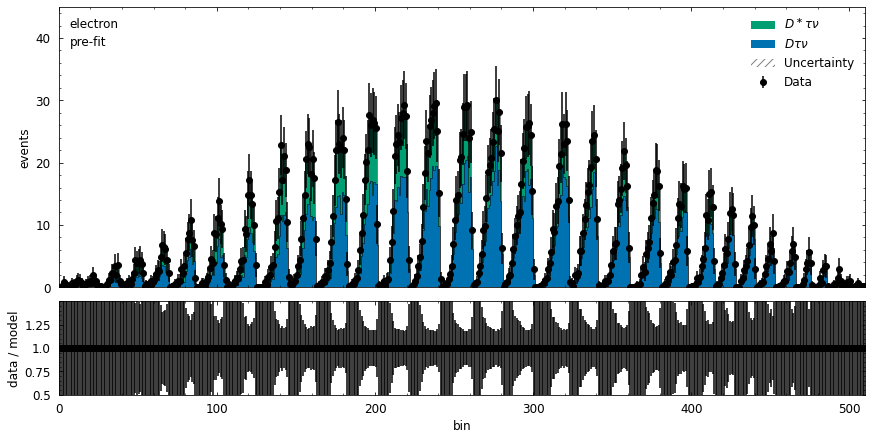

In [102]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [11]:
%%time
## 333/fb template and with staterror
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2643                       │            Nfcn = 264610             │
│ EDM = 5.86e-09 (Goal: 0.0002)    │           time = 152.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 2642.652663 at

INFO - cabinetry.fit - staterror_signal_region[82]        =  1.0000 +/- 0.1587
INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0000 +/- 0.1511
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0000 +/- 0.1278
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0000 +/- 0.1125
INFO - cabinetry.fit - staterror_signal_region[86]        =  1.0000 +/- 0.1139
INFO - cabinetry.fit - staterror_signal_region[87]        =  1.0000 +/- 0.0986
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0000 +/- 0.0976
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0000 +/- 0.1099
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0000 +/- 0.1100
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.0000 +/- 0.1963
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[93]        =  1.0000 +/- 0.4084
INFO - cabinetry.fit - staterror_signal_region[94]  

INFO - cabinetry.fit - staterror_signal_region[186]       =  1.0000 +/- 0.1083
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0000 +/- 0.1072
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0000 +/- 0.0882
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0000 +/- 0.0745
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0000 +/- 0.0702
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0000 +/- 0.0668
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0000 +/- 0.0609
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0000 +/- 0.0705
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0000 +/- 0.0681
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0000 +/- 0.0705
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0000 +/- 0.0765
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0000 +/- 0.0911
INFO - cabinetry.fit - staterror_signal_region[198] 

INFO - cabinetry.fit - staterror_signal_region[290]       =  1.0000 +/- 0.0599
INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0000 +/- 0.0586
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0000 +/- 0.0573
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0000 +/- 0.0554
INFO - cabinetry.fit - staterror_signal_region[294]       =  1.0000 +/- 0.0577
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0000 +/- 0.0588
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0000 +/- 0.0633
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0000 +/- 0.0728
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0000 +/- 0.1217
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0000 +/- 0.4980
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0000 +/- 0.2676
INFO - cabinetry.fit - staterror_signal_region[302] 

INFO - cabinetry.fit - staterror_signal_region[394]       =  1.0000 +/- 0.0497
INFO - cabinetry.fit - staterror_signal_region[395]       =  1.0000 +/- 0.0513
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0000 +/- 0.0520
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0000 +/- 0.0536
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0000 +/- 0.0616
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0000 +/- 0.0671
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0000 +/- 0.1155
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0000 +/- 0.5004
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0000 +/- 0.4074
INFO - cabinetry.fit - staterror_signal_region[405]       =  1.0000 +/- 0.3530
INFO - cabinetry.fit - staterror_signal_region[406] 

INFO - cabinetry.fit - staterror_signal_region[498]       =  1.0000 +/- 0.1258
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0000 +/- 0.4978
INFO - cabinetry.fit - staterror_signal_region[500]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.0000 +/- 0.3530
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0000 +/- 0.3162
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0000 +/- 0.1719
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0000 +/- 0.1149
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0000 +/- 0.0718
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0000 +/- 0.0547
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0000 +/- 0.0514
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0000 +/- 0.0459
INFO - cabinetry.fit - staterror_signal_region[510] 

INFO - cabinetry.fit - staterror_signal_region[602]       =  1.0000 +/- 0.3530
INFO - cabinetry.fit - staterror_signal_region[603]       =  1.0000 +/- 0.4978
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0000 +/- 0.2358
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0000 +/- 0.1445
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0000 +/- 0.0629
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0000 +/- 0.0468
INFO - cabinetry.fit - staterror_signal_region[608]       =  1.0000 +/- 0.0434
INFO - cabinetry.fit - staterror_signal_region[609]       =  1.0000 +/- 0.0386
INFO - cabinetry.fit - staterror_signal_region[610]       =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.0000 +/- 0.0326
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_signal_region[613]       =  1.0000 +/- 0.0492
INFO - cabinetry.fit - staterror_signal_region[614] 

INFO - cabinetry.fit - staterror_signal_region[706]       =  1.0000 +/- 0.0814
INFO - cabinetry.fit - staterror_signal_region[707]       =  1.0000 +/- 0.0846
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[709]       =  1.0000 +/- 0.7008
INFO - cabinetry.fit - staterror_signal_region[710]       =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_signal_region[711]       =  1.0000 +/- 0.1293
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0000 +/- 0.0835
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0000 +/- 0.1119


CPU times: user 4min 17s, sys: 4.12 s, total: 4min 21s
Wall time: 3min 57s


In [31]:
toy_pars[:8]

[0.1310227205910763,
 0.06125947561513536,
 0.01778496954787699,
 0.013140250750420529,
 0.16452134544805178,
 0.18342355968276713,
 0.12526079739576418,
 0.1486043465869597]

In [32]:
%%time
## 3/ab template and weighted to 0.12
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=toys[0],
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2103                       │      Nfcn = 328244, Ngrad = 61       │
│ EDM = 0.000494 (Goal: 0.0002)    │           time = 227.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_signal_region[82]        =  0.9326 +/- 0.0720
INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0079 +/- 0.0689
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.9995 +/- 0.0603
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9539 +/- 0.0525
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9533 +/- 0.0484
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9456 +/- 0.0478
INFO - cabinetry.fit - staterror_signal_region[88]        =  0.8515 +/- 0.0517
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9962 +/- 0.0561
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0029 +/- 0.0852
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.6996 +/- 0.1819
INFO - cabinetry.fit - staterror_signal_region[92]        =  0.6660 +/- 0.9733
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.4501 +/- 0.4948
INFO - cabinetry.fit - staterror_signal_region[94]  

INFO - cabinetry.fit - staterror_signal_region[186]       =  1.0147 +/- 0.0745
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0289 +/- 0.0692
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0651 +/- 0.0587
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0408 +/- 0.0526
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9258 +/- 0.0465
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0136 +/- 0.0399
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9505 +/- 0.0388
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9968 +/- 0.0331
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0203 +/- 0.0312
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0070 +/- 0.0296
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0058 +/- 0.0299
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0121 +/- 0.0313
INFO - cabinetry.fit - staterror_signal_region[198] 

INFO - cabinetry.fit - staterror_signal_region[290]       =  1.0019 +/- 0.0379
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9431 +/- 0.0356
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9732 +/- 0.0333
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0439 +/- 0.0312
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9974 +/- 0.0302
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0215 +/- 0.0270
INFO - cabinetry.fit - staterror_signal_region[296]       =  0.9479 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.9670 +/- 0.0265
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0428 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0148 +/- 0.0254
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0144 +/- 0.0256
INFO - cabinetry.fit - staterror_signal_region[301]       =  0.9904 +/- 0.0258
INFO - cabinetry.fit - staterror_signal_region[302] 

INFO - cabinetry.fit - staterror_signal_region[394]       =  1.1205 +/- 0.1597
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9893 +/- 0.1299
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0325 +/- 0.0853
INFO - cabinetry.fit - staterror_signal_region[397]       =  0.9190 +/- 0.0637
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0172 +/- 0.0515
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0257 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0057 +/- 0.0303
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9559 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0280 +/- 0.0232
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0046 +/- 0.0215
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.9983 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9986 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[406] 

INFO - cabinetry.fit - staterror_signal_region[498]       =  1.0241 +/- 0.7088
INFO - cabinetry.fit - staterror_signal_region[499]       =  0.9925 +/- 0.2420
INFO - cabinetry.fit - staterror_signal_region[500]       =  1.0981 +/- 0.1810
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.1779 +/- 0.1643
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0688 +/- 0.1358
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.9401 +/- 0.1017
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0150 +/- 0.0838
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0022 +/- 0.0527
INFO - cabinetry.fit - staterror_signal_region[506]       =  0.9820 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9574 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0401 +/- 0.0243
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0073 +/- 0.0213
INFO - cabinetry.fit - staterror_signal_region[510] 

INFO - cabinetry.fit - staterror_signal_region[602]       =  0.9902 +/- 0.0144
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9950 +/- 0.0140
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0086 +/- 0.0160
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0176 +/- 0.0192
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0015 +/- 0.0224
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9995 +/- 0.0264
INFO - cabinetry.fit - staterror_signal_region[608]       =  1.0480 +/- 0.0460
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8957 +/- 0.2194
INFO - cabinetry.fit - staterror_signal_region[610]       =  1.0368 +/- 0.1865
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.1188 +/- 0.1778
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0952 +/- 0.1714
INFO - cabinetry.fit - staterror_signal_region[613]       =  1.0482 +/- 0.1193
INFO - cabinetry.fit - staterror_signal_region[614] 

INFO - cabinetry.fit - staterror_signal_region[706]       =  0.8985 +/- 0.1433
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.7907 +/- 0.1248
INFO - cabinetry.fit - staterror_signal_region[708]       =  0.9367 +/- 0.0518
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9384 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.9952 +/- 0.0217
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.9676 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.9989 +/- 0.0177
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0074 +/- 0.0176
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0274 +/- 0.0278
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9495 +/- 0.0895
INFO - cabinetry.fit - staterror_signal_region[716]       =  0.4912 +/- 0.4443
INFO - cabinetry.fit - staterror_signal_region[717]       =  1.3985 +/- 0.4450
INFO - cabinetry.fit - staterror_signal_region[718] 

CPU times: user 5min 53s, sys: 5.98 s, total: 5min 59s
Wall time: 5min 30s


In [ ]:
%%time
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters),)
                                #minos=model.config.parameters[:7])

In [22]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

$D\ell\nu$_norm: 1.000 +/- 0.016
$D\tau\nu$_norm: 1.000 +/- 0.302
$D^\ast\ell\nu$_norm: 1.000 +/- 0.036
$D^\ast\tau\nu$_norm: 1.000 +/- 0.472
$D^{\ast\ast}\tau\nu$_norm: 1.000 +/- 0.645
bkg_fakeD_norm: 1.000 +/- 0.046
gap_non_$D^{\ast\ast}\ell\nu$_norm: 1.000 +/- 0.291
res_$D^{\ast\ast}\ell\nu$_norm: 1.000 +/- 0.050
staterror_signal_region[0]: 1.000 +/- 0.525
staterror_signal_region[1]: 1.000 +/- 0.525
staterror_signal_region[2]: 1.000 +/- 0.444
staterror_signal_region[3]: 1.000 +/- 0.445
staterror_signal_region[4]: 1.000 +/- 0.525
staterror_signal_region[5]: 1.000 +/- 0.327
staterror_signal_region[6]: 1.000 +/- 0.328
staterror_signal_region[7]: 1.000 +/- 0.264
staterror_signal_region[8]: 1.000 +/- 0.373
staterror_signal_region[9]: 1.000 +/- 0.399
staterror_signal_region[10]: 1.000 +/- 0.452
staterror_signal_region[11]: 1.000 +/- 0.327
staterror_signal_region[12]: 1.000 +/- 0.236
staterror_signal_region[13]: 1.000 +/- 0.278
staterror_signal_region[14]: 1.000 +/- 0.236
staterror_signal_

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


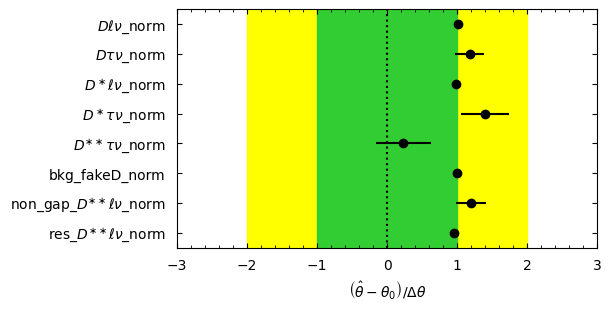

In [7]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


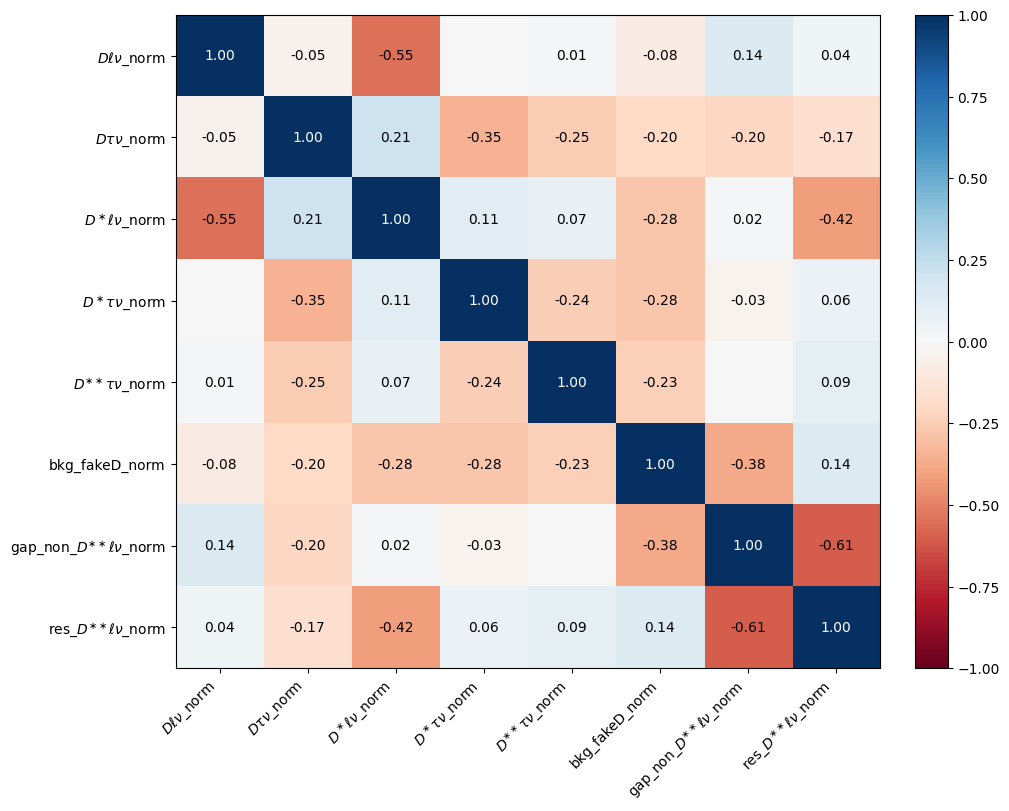

In [15]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.25)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │              Nfcn = 73               │
│ EDM = 2.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3955.304735 at

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3960                       │        Nfcn = 101, Ngrad = 9         │
│ EDM = 0.000513 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3960.403538 at

DEBUG - cabinetry.fit - -2 log(L) = 3957.894671 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.565
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3958                       │         Nfcn = 99, Ngrad = 8         │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3956.059152 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.778
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │        Nfcn = 101, Ngrad = 8         │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.321419 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.990
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │         Nfcn = 75, Ngrad = 2         │
│ EDM = 0.000493 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.679596 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.202
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │         Nfcn = 95, Ngrad = 8         │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3957.135240 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.414
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3957                       │         Nfcn = 98, Ngrad = 9         │
│ EDM = 6.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3959.692705 at best-fit point
INFO - cabinetry.visualize.utils - saving figure as figures/scan_$D\tau\nu$_norm.pdf


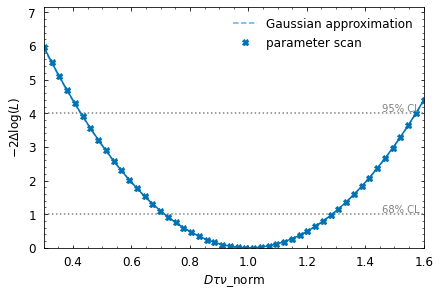

In [80]:
scan_0=cabinetry.fit.scan(model=model, data=data,par_name=r'$D\tau\nu$_norm',par_range=[0.3,1.6],n_steps=50)
cabinetry.visualize.scan(scan_0)

INFO - cabinetry.visualize.utils - saving figure as figures/electron_postfit.pdf


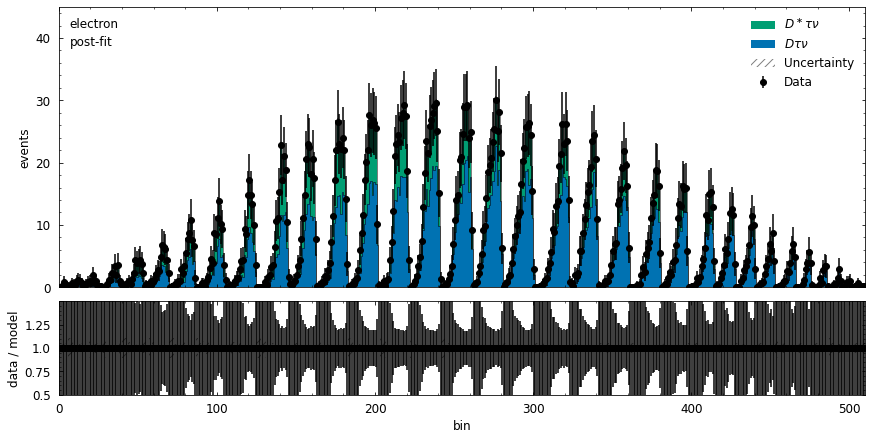

In [105]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)
for i in _:
    i['figure'].set_figwidth(12)

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 